# Decision Analysis - Project 3

## Installs and Imports

In [229]:
!pip install shap

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import random
import os
import warnings
import shap

In [231]:
def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [232]:
set_all_seeds(42)
warnings.filterwarnings("ignore")

## Functions, Models and Utilities

### Utils

In [233]:
def plot_columns(df, figsize = (12, 8), color="grey"):
    num_cols = len(df.columns)
    num_rows = (num_cols + 1) // 2
    fig, axes = plt.subplots(num_rows, 2, figsize=figsize)
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    for i, column in enumerate(df.columns):
        ax = axes[i // 2, i % 2]
        df[column].plot(kind='hist', ax=ax, title=column, color=color)
        ax.set_title(f"Distribution for {column}")
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    fig.suptitle("Data Distribution Plot")
    plt.tight_layout()
    plt.show()

In [234]:
def plot_stats(accuracy, test_accuracy, f1, f1_test, auc, auc_test):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    color = 'grey'
    axes[0].bar(['Train', 'Test'], [accuracy, test_accuracy], color=color)
    axes[0].axhline(y=0.5, color='red', linestyle='--', label='Random Guess')
    axes[0].set_title('Accuracy')
    axes[0].legend()
    axes[1].bar(['Train', 'Test'], [f1, f1_test], color=color)
    axes[1].set_title('F1 Score')
    axes[2].bar(['Train', 'Test'], [auc, auc_test], color=color)
    axes[2].set_title('AUC')
    plt.tight_layout()
    plt.show()

In [235]:
def use_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_train)
    accuracy = round(accuracy_score(y_train, y_preds), 4)
    f1 = round(f1_score(y_train, y_preds), 4)
    y_preds_positive = model.predict_proba(X_train)[:, 1]
    auc = round(roc_auc_score(y_train, y_preds_positive), 4)

    y_preds = model.predict(X_test)
    accuracy_test = round(accuracy_score(y_test, y_preds), 4)
    f1_test = round(f1_score(y_test, y_preds), 4)
    y_preds_positive = model.predict_proba(X_test)[:, 1]
    auc_test = round(roc_auc_score(y_test, y_preds_positive), 4)
    return model, accuracy, f1, auc, accuracy_test, f1_test, auc_test

In [236]:
def get_logistic_regression_changed_prediction(test_example, columns, coefficients, intercept, classifier):
    sum= 0.0
    epsilon = 1e-3
    example_list = list(test_example)
    zipped_lists = zip(coefficients, example_list, range(len(coefficients)))
    sorted_lists = sorted(zipped_lists, reverse=True)
    sorted_coeffs, example_list, original_order = zip(*sorted_lists)
    example_list = list(example_list)
    original_order = list(original_order)
    sorted_coeffs = list(sorted_coeffs)

    for i in range(len(example_list)):
        sum += example_list[i]*sorted_coeffs[i]
    sum += intercept
    prev_examples = example_list.copy()
    if sum>=0:
        for i in range(len(example_list)):
            val = -1*intercept-epsilon
            for j in range(len(example_list)):
                if i != j:
                    val -= example_list[j]*sorted_coeffs[j]
            example_list[i] = val/sorted_coeffs[i]
            if example_list[i]<0:
                example_list[i] = 0
            elif example_list[i]>1:
                example_list[i] = 1
            else:
                break
    else:
        for i in range(len(example_list)):
            val = -1*intercept+epsilon
            for j in range(len(example_list)):
                if i != j:
                    val -= example_list[j]*sorted_coeffs[j]
            example_list[i] = val/sorted_coeffs[i]
            if example_list[i]<0:
                example_list[i] = 0
            elif example_list[i]>1:
                example_list[i] = 1
            else:
                break

    original_order = [original_order.index(i) for i in range(len(original_order))]
    example_list = [example_list[i] for i in original_order]
    prev_examples = [prev_examples[i] for i in original_order]
    rounded_examples = [round(example, 4) for example in example_list]
    rounded_prevs = [round(example, 4) for example in prev_examples]
    differences = list(np.array(prev_examples) - np.array(example_list))
    differences = [round(diff, 4) for diff in differences]
    print(f"Columns in order: {columns}")
    print(f"Original Example: {rounded_prevs}")
    print(f"New Example Assigned to a different class: {rounded_examples}")
    print(f"Minimal Differences: {differences}")
    print(f"Model's original decision {classifier.predict([prev_examples])}")
    print(f"Model's new decision: {classifier.predict([example_list])}")

In [237]:
def change_class_by_sampling(test_example, columns, coefficients, intercept, classifier):
    epsilon = 1e-3
    example_list = list(test_example)
    prev_examples = example_list.copy()
    original_class = classifier.predict([example_list])[0]
    i=0
    while True:
        zipped_lists = zip(coefficients, example_list, range(len(coefficients)))
        sorted_lists = sorted(zipped_lists, reverse=True)
        sorted_coeffs, example_list, original_order = zip(*sorted_lists)
        example_list = list(example_list)
        original_order = list(original_order)
        sorted_coeffs = list(sorted_coeffs)
        if original_class == 1:
            example_list[i] -= epsilon
        else:
            example_list[i] += epsilon
        if example_list[i]<=0:
            example_list[i] = 0
            i+=1
        elif example_list[i]>=1:
            example_list[i] = 1
            i+=1
        original_order = [original_order.index(i) for i in range(len(original_order))]
        example_list = [example_list[i] for i in original_order]
        new_class = classifier.predict([example_list])[0]
        if new_class != original_class:
            break

    rounded_examples = [round(example, 4) for example in example_list]
    rounded_prevs = [round(example, 4) for example in prev_examples]
    differences = list(np.array(prev_examples) - np.array(example_list))
    differences = [round(diff, 4) for diff in differences]
    print(f"Columns in order: {columns}")
    print(f"Original Example: {rounded_prevs}")
    print(f"New Example Assigned to a different class: {rounded_examples}")
    print(f"Minimal Differences: {differences}")
    print(f"Model's original decision {original_class}")
    print(f"Model's new decision: {new_class}")

### Neural MCDA

In [238]:
def morbius_transform(input_row):
    result = list(input_row)
    for i in range(len(input_row)):
        for j in range(i+1, len(input_row)):
            result.append(min(input_row[i], input_row[j]))

    return np.array(result)

In [239]:
class CriteriaLayer(nn.Linear):
    def __init__(self, num_in_features:int, include_bias:bool=False, min_weight:float=1e-8):
        super().__init__(num_in_features, 1, include_bias)
        self.is_bias = include_bias
        self.min_w = min_weight
        if include_bias:
            nn.init.uniform_(self.bias, self.min_w ,1.0)
        else:
            self.bias = None

    def reset_parameters(self):
        nn.init.uniform_(self.weight, 0.1, 1.0)

    def ensure_proper_weights(self):
        with torch.no_grad():
            self.weight.data[self.weight.data<0]=self.min_w
        weights = self.weight
        return weights

    def forward(self, input:torch.Tensor)->torch.Tensor:
        weights = self.ensure_proper_weights()
        return F.linear(input, weights, self.bias)

In [240]:
class InteractionLayer(nn.Linear):
    def __init__(self, num_in_features:int, criterion_layer:CriteriaLayer):
        num_interactions = ((num_in_features-1)*num_in_features)//2
        super().__init__(num_interactions, 1, False)
        self.in_features = num_in_features
        self.criterion_layer = criterion_layer
        self.num_interactions = num_interactions

    def reset_parameters(self):
        nn.init.normal_(self.weight, 0.0, 0.1)

    def ensure_proper_weights(self):
        with torch.no_grad():
            w_i=0
            w = self.criterion_layer.ensure_proper_weights()
            for i in range(self.in_features):
                for j in range(i+1,self.in_features):
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,i])
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,j])
                    w_i+=1
        weights = self.weight
        return weights

    def forward(self, input:torch.Tensor)->torch.Tensor:
        weights = self.ensure_proper_weights()
        return F.linear(input, weights, None)

In [241]:
class ThresholdLayer(nn.Module):
    def __init__(self, threshold: float = None, requires_grad: bool = True):
        super().__init__()
        if threshold is None:
            self.threshold = nn.Parameter(torch.FloatTensor(1).uniform_(0.1, 0.9), requires_grad=requires_grad)
        else:
            self.threshold = nn.Parameter(torch.FloatTensor([threshold]), requires_grad=requires_grad)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        return x - self.threshold

In [242]:
class ChoquetIntegralConstrained(nn.Module):
    def __init__(self, num_criteria:int, mobius_transform):
        super().__init__()
        self.num_criteria = num_criteria
        self.criteria_layer = CriteriaLayer(num_criteria)
        self.interaction_layer = InteractionLayer(num_criteria, self.criteria_layer)
        self.threshold_layer = ThresholdLayer()
        self.transform = mobius_transform

    def preprocess(self, input: np.array)->np.array:
        processed = []
        for row in input:
            processed.append(self.transform(row))
        return np.array(processed)

    def forward(self, input:torch.Tensor)->torch.Tensor:
        if len(input.shape)==3:
            input = input[:,0,:]

        x_wi = self.criteria_layer(input[:,:self.num_criteria])
        x_wij = self.interaction_layer(input[:,self.num_criteria:])
        weight_sum = self.criteria_layer.ensure_proper_weights().sum()+self.interaction_layer.ensure_proper_weights().sum()
        score =  (x_wi+x_wij)/(weight_sum)
        output = self.threshold_layer(score)
        return output.squeeze()

In [243]:
def Regret(output: torch.FloatTensor, target: torch.LongTensor) -> torch.FloatTensor:
    return torch.mean(F.relu(-(target >= 1).float() * output) + F.relu((target < 1).float() * output))

### ANN

In [244]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x.squeeze()

class CompatibleTorchModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model, optimizer, criterion, num_epochs, custom_acc_threshold = False):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.custom_acc_threshold = custom_acc_threshold

    def fit(self, X_train, y_train):
        print("Fitting Neural Network Model")
        self.model.train()
        train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        history = {'epoch': [], 'accuracy': [], 'loss': []}
        for epoch in range(self.num_epochs):
            epoch_loss = 0.0
            correct = 0
            total = 0
            for inputs, targets in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() * inputs.size(0)
                predicted = outputs.detach().numpy()
                if self.custom_acc_threshold:
                    predicted[predicted>=0.0] = 1
                    predicted[predicted<0.0] = 0
                else:
                    predicted[predicted>=0.5] = 1
                    predicted[predicted<0.5] = 0
                total += len(targets)
                expected = targets.numpy()
                correct += np.sum(predicted == expected)
            epoch_loss /= len(train_loader.dataset)
            epoch_accuracy = correct / total
            print(f"Training Results - Epoch: {epoch+1}  Avg accuracy: {round(epoch_accuracy, 4)} Avg loss: {round(epoch_loss, 4)}")
            history['epoch'].append(epoch)
            history['accuracy'].append(epoch_accuracy)
            history['loss'].append(epoch_loss)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['epoch'], history['loss'], label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history['epoch'], history['accuracy'], label='Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def predict(self, X):
        self.model.eval()
        predictions = []
        for temp_X in X:
            X_input = torch.tensor(temp_X).float()
            with torch.no_grad():
                output = self.model(X_input.unsqueeze(0))
            if self.custom_acc_threshold:
                output = 1 if output > 0.0 else 0
            else:
                output = 1 if output > 0.5 else 0
            predictions.append(output)
        return np.array(predictions)

    def predict_proba(self, X):
        self.model.eval()
        predictions = []
        for temp_X in X:
            X_input = torch.tensor(temp_X).float()
            with torch.no_grad():
                output = self.model(X_input.unsqueeze(0))
                output = np.round(output.item(), 4)
                if self.custom_acc_threshold:
                    output += 0.5
                if output>1:
                    output = 1
            predictions.append([1-output, output])
        return np.array(predictions)

## Data

In [245]:
data = pd.read_csv("/content/mammographic.csv")
data = (data - data.min()) / (data.max() - data.min())
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data

,BI-RADS,Age,Shape,Margin,Density,Severity
0,0.072727,0.525641,0.000000,0.00,0.666667,0.0
1,0.072727,0.333333,0.333333,0.00,0.666667,0.0
2,0.090909,0.474359,1.000000,1.00,0.666667,0.0
3,0.072727,0.076923,0.333333,0.00,0.666667,0.0
4,0.072727,0.358974,0.000000,0.00,0.666667,0.0
...,...,...,...,...,...,...
825,0.072727,0.615385,0.000000,0.00,0.666667,0.0
826,0.072727,0.038462,0.333333,0.00,0.666667,0.0
827,0.090909,0.833333,1.000000,0.75,0.666667,1.0
828,0.090909,0.628205,1.000000,1.00,0.666667,1.0


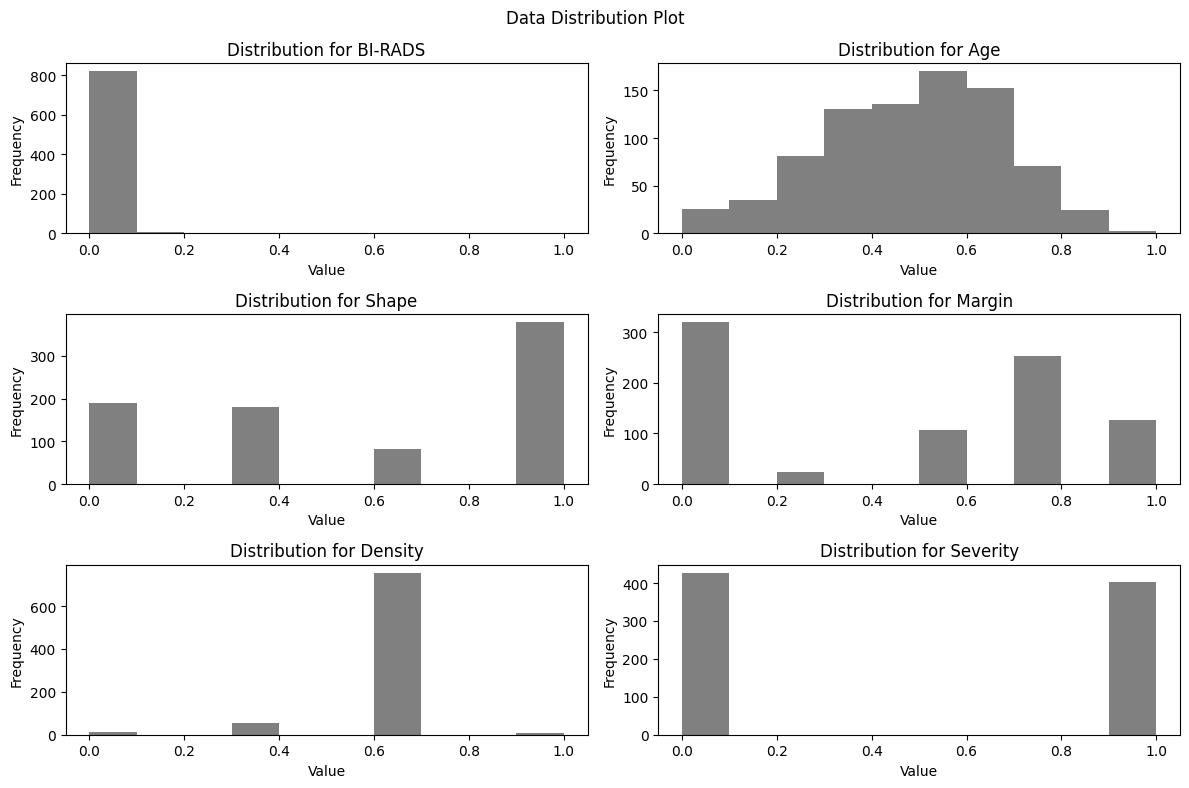

In [246]:
plot_columns(data)

In [247]:
X = data.drop(columns = ["Severity"])
y = data["Severity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Simple Explainable Model - Logistic Regression

### Training

In [248]:
simple_model = LogisticRegression()
simple_model, accuracy, f1, auc, accuracy_test, f1_test, auc_test = use_model(simple_model, X_train, y_train, X_test, y_test)

In [249]:
print(f"Train set accuracy: {accuracy}")
print(f"Train set F1: {f1}")
print(f"Train set AUC: {auc}")
print(f"Test set accuracy: {accuracy_test}")
print(f"Test set F1: {f1_test}")
print(f"Test set AUC: {auc_test}")

Train set accuracy: 0.8163
Train set F1: 0.8174
Train set AUC: 0.8773
Test set accuracy: 0.7711
Test set F1: 0.7912
Test set AUC: 0.8444


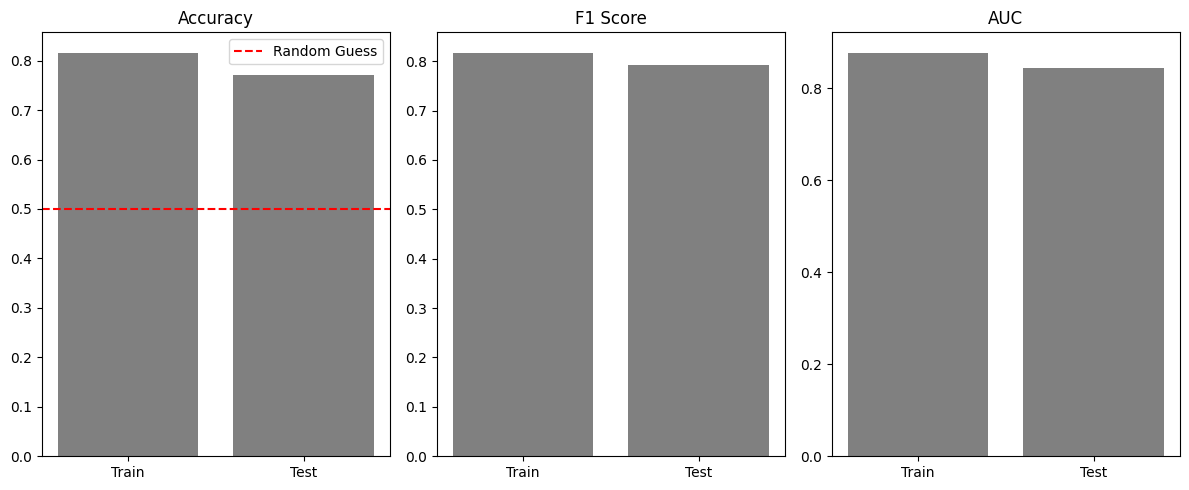

In [250]:
plot_stats(accuracy, accuracy_test, f1, f1_test, auc, auc_test)

### 2.1. Explanation of the decisions

In [251]:
feature_names = X_train.columns
coefficients = simple_model.coef_
intercept = simple_model.intercept_

print(f"Coefficients: {coefficients}")
print(f"intercept: {intercept}")

Coefficients: [[1.16315803 3.33063052 1.8128958  1.68386309 0.39304664]]
intercept: [-3.91537883]


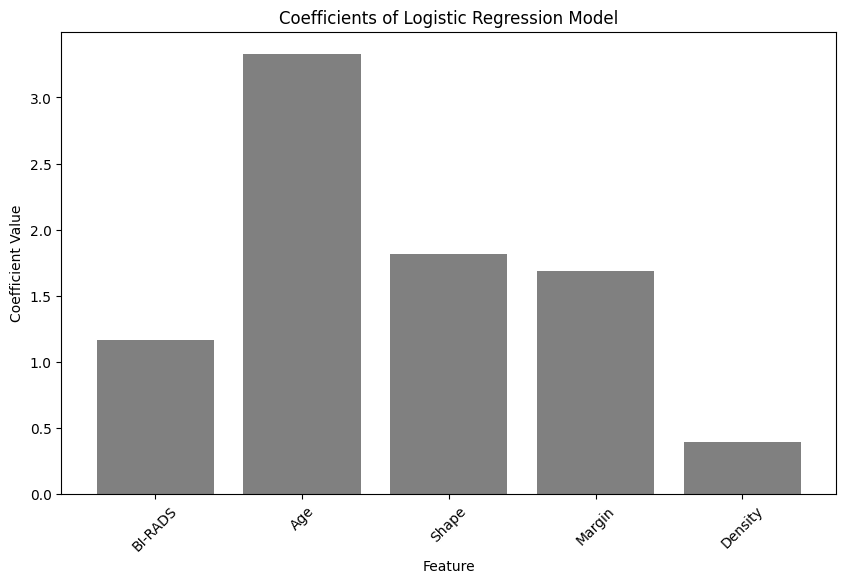

In [252]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), coefficients[0], color="grey")
plt.xticks(range(len(feature_names)), feature_names, rotation=45)
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of Logistic Regression Model')
plt.show()

In [253]:
X_test

,BI-RADS,Age,Shape,Margin,Density
162,0.090909,0.730769,1.000000,0.75,0.666667
305,0.072727,0.666667,1.000000,0.25,0.333333
24,0.090909,0.538462,1.000000,0.50,0.666667
667,0.072727,0.294872,0.333333,0.25,0.666667
574,0.072727,0.705128,1.000000,0.50,0.666667
...,...,...,...,...,...
695,0.090909,0.743590,0.000000,0.75,0.666667
379,0.072727,0.589744,0.333333,0.75,0.666667
208,0.072727,0.294872,0.000000,0.00,0.666667
388,0.072727,0.435897,1.000000,0.75,0.666667


In [254]:
test_example_1 = X_test.iloc[0]
test_label_1 = simple_model.predict(X_test.iloc[0].values.reshape(1, -1))[0]
test_example_2 = X_test.iloc[1]
test_label_2 = simple_model.predict(X_test.iloc[1].values.reshape(1, -1))[0]
test_example_3 = X_test.iloc[9] #taking the 9th example, since we wanted variety with classes
test_label_3 = simple_model.predict(X_test.iloc[9].values.reshape(1, -1))[0]
print(f"Test example:\n{test_example_1}")
print(f"\nAssigned Label: {test_label_1}")
print("________________________________")
print(f"Test example:\n{test_example_2}")
print(f"\nAssigned Label: {test_label_2}")
print("________________________________")
print(f"Test example:\n{test_example_3}")
print(f"\nAssigned Label: {test_label_3}")

Test example:
BI-RADS    0.090909
Age        0.730769
Shape      1.000000
Margin     0.750000
Density    0.666667
Name: 162, dtype: float64

Assigned Label: 1.0
________________________________
Test example:
BI-RADS    0.072727
Age        0.666667
Shape      1.000000
Margin     0.250000
Density    0.333333
Name: 305, dtype: float64

Assigned Label: 1.0
________________________________
Test example:
BI-RADS    0.072727
Age        0.282051
Shape      0.333333
Margin     0.000000
Density    0.666667
Name: 462, dtype: float64

Assigned Label: 0.0


#### Changes from Theoretical Calculations



In [255]:
get_logistic_regression_changed_prediction(test_example_1, list(X_train.columns), coefficients[0], intercept[0], simple_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.0909, 0.7308, 1.0, 0.75, 0.6667]
New Example Assigned to a different class: [0.0909, 0.1414, 1.0, 0.75, 0.6667]
Minimal Differences: [0.0, 0.5894, 0.0, 0.0, 0.0]
Model's original decision [1.]
Model's new decision: [0.]


In [256]:
get_logistic_regression_changed_prediction(test_example_2, list(X_train.columns), coefficients[0], intercept[0], simple_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.0727, 0.6667, 1.0, 0.25, 0.3333]
New Example Assigned to a different class: [0.0727, 0.4398, 1.0, 0.25, 0.3333]
Minimal Differences: [0.0, 0.2268, 0.0, 0.0, 0.0]
Model's original decision [1.]
Model's new decision: [0.]


In [257]:
get_logistic_regression_changed_prediction(test_example_3, list(X_train.columns), coefficients[0], intercept[0], simple_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.0727, 0.2821, 0.3333, 0.0, 0.6667]
New Example Assigned to a different class: [0.0727, 0.8904, 0.3333, 0.0, 0.6667]
Minimal Differences: [0.0, -0.6083, 0.0, 0.0, 0.0]
Model's original decision [0.]
Model's new decision: [1.]


#### Changes from Sampling

In [258]:
change_class_by_sampling(test_example_1, list(X_train.columns), coefficients[0], intercept[0], simple_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.0909, 0.7308, 1.0, 0.75, 0.6667]
New Example Assigned to a different class: [0.0909, 0.1408, 1.0, 0.75, 0.6667]
Minimal Differences: [0.0, 0.59, 0.0, 0.0, 0.0]
Model's original decision 1.0
Model's new decision: 0.0


In [259]:
change_class_by_sampling(test_example_2, list(X_train.columns), coefficients[0], intercept[0], simple_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.0727, 0.6667, 1.0, 0.25, 0.3333]
New Example Assigned to a different class: [0.0727, 0.4397, 1.0, 0.25, 0.3333]
Minimal Differences: [0.0, 0.227, 0.0, 0.0, 0.0]
Model's original decision 1.0
Model's new decision: 0.0


In [260]:
change_class_by_sampling(test_example_3, list(X_train.columns), coefficients[0], intercept[0], simple_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.0727, 0.2821, 0.3333, 0.0, 0.6667]
New Example Assigned to a different class: [0.0727, 0.8911, 0.3333, 0.0, 0.6667]
Minimal Differences: [0.0, -0.609, 0.0, 0.0, 0.0]
Model's original decision 0.0
Model's new decision: 1.0


### SHAP explanation

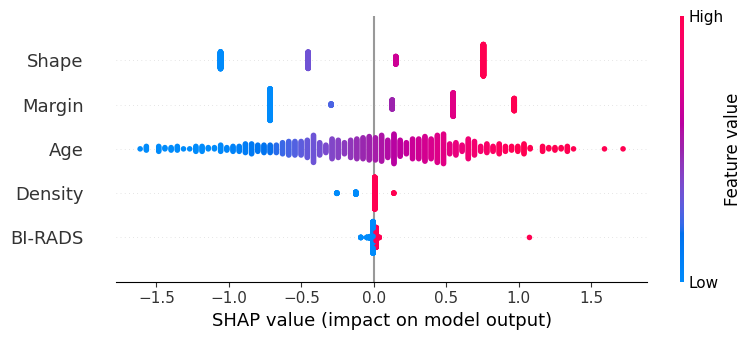

In [261]:
explainer = shap.Explainer(simple_model, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

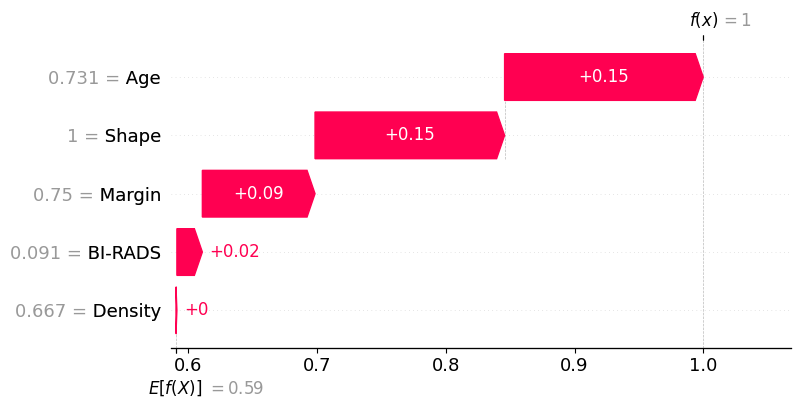

In [304]:
shap.plots.waterfall(shap_values[0])

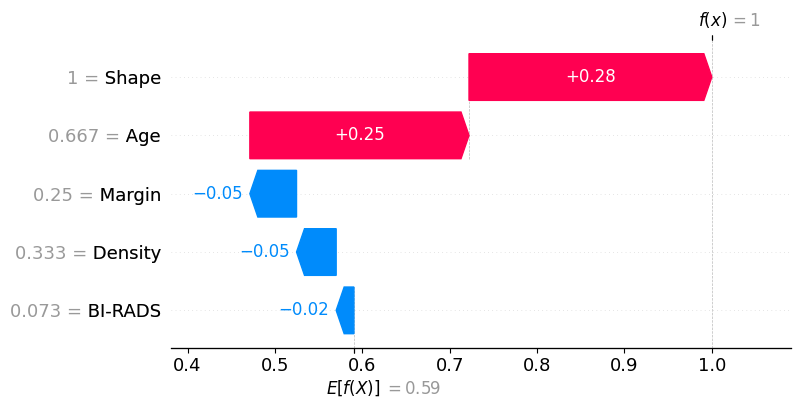

In [305]:
shap.plots.waterfall(shap_values[1])

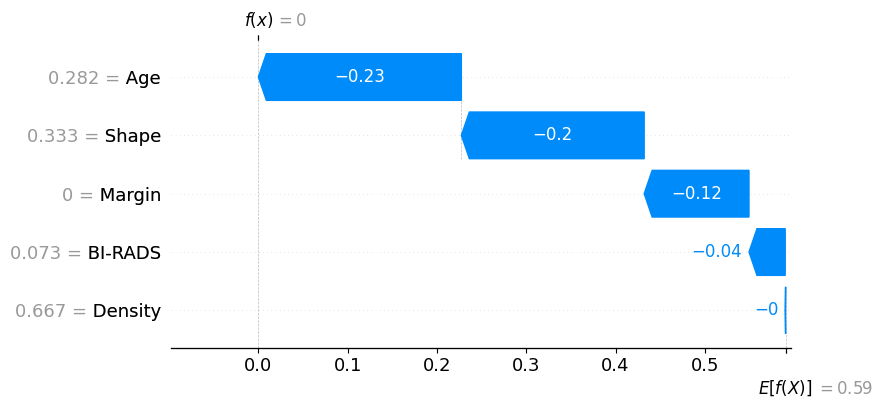

In [306]:
shap.plots.waterfall(shap_values[9])

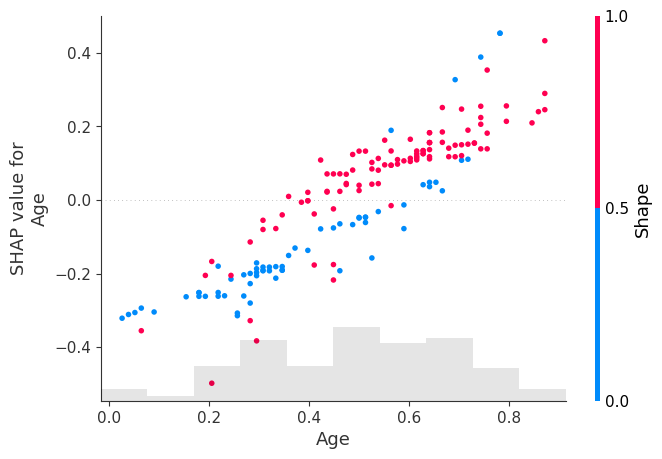

In [313]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values)

#### Conclusions

TODO: write

### 2.2. Interpretation of the model

• Based on the parameters obtained, can we say something about the user’s preferences? <br>
• What was the influence of the criteria? Are there any criteria that have no effect, or have a decisive influence? <br>
• Are there any dependencies between the criteria? <br>
• What is the nature of the criterion, gain, cost, non-monotonic? <br>
• Whether there are any preference thresholds? Are there any evaluations on criteria that are indifferent in terms of preferences? <br>
• Interpret the model by at least one (Global Surrogate, Partial Dependence Plot, Permutation Feature Importance ...) <br>

TODO: write

## Interpretable Neural MCDA - ANN-Ch-Constr.

In [285]:
lr = 1e-3
weight_decay = 1e-4
criterion = Regret
num_epochs = 100

Fitting Neural Network Model
Training Results - Epoch: 1  Avg accuracy: 0.7786 Avg loss: 0.0264
Training Results - Epoch: 2  Avg accuracy: 0.7831 Avg loss: 0.0249
Training Results - Epoch: 3  Avg accuracy: 0.7831 Avg loss: 0.0234
Training Results - Epoch: 4  Avg accuracy: 0.7861 Avg loss: 0.0221
Training Results - Epoch: 5  Avg accuracy: 0.7861 Avg loss: 0.0208
Training Results - Epoch: 6  Avg accuracy: 0.7907 Avg loss: 0.0196
Training Results - Epoch: 7  Avg accuracy: 0.7922 Avg loss: 0.0186
Training Results - Epoch: 8  Avg accuracy: 0.7937 Avg loss: 0.0176
Training Results - Epoch: 9  Avg accuracy: 0.7922 Avg loss: 0.0167
Training Results - Epoch: 10  Avg accuracy: 0.7922 Avg loss: 0.0157
Training Results - Epoch: 11  Avg accuracy: 0.7982 Avg loss: 0.0149
Training Results - Epoch: 12  Avg accuracy: 0.7997 Avg loss: 0.014
Training Results - Epoch: 13  Avg accuracy: 0.7997 Avg loss: 0.0131
Training Results - Epoch: 14  Avg accuracy: 0.7952 Avg loss: 0.0122
Training Results - Epoch: 15 

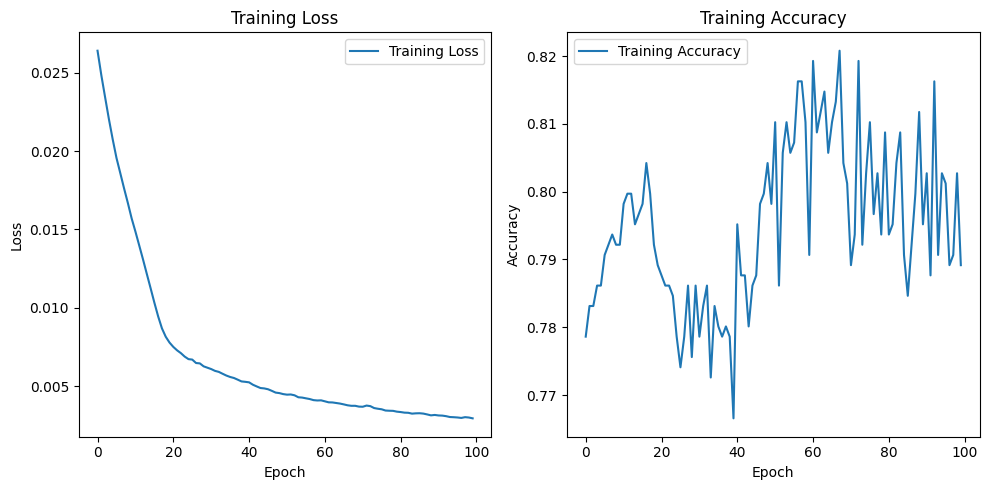

In [286]:
num_criteria = len(X_train.columns)
neural_MCDA_model = ChoquetIntegralConstrained(num_criteria = num_criteria, mobius_transform = morbius_transform)
X_train_processed = neural_MCDA_model.preprocess(X_train.values)
X_test_processed = neural_MCDA_model.preprocess(X_test.values)
optimizer = optim.AdamW(neural_MCDA_model.parameters(), lr=lr, weight_decay=weight_decay)
neural_MCDA_compatible = Compatible_Torch_Model(neural_MCDA_model, optimizer, criterion, num_epochs, custom_acc_threshold=True)
neural_MCDA_compatible, accuracy, f1, auc, accuracy_test, f1_test, auc_test = use_model(neural_MCDA_compatible, X_train_processed, y_train.values, X_test_processed, y_test.values)
neural_MCDA_model = neural_MCDA_compatible.model

In [287]:
print(f"Train set accuracy: {accuracy}")
print(f"Train set F1: {f1}")
print(f"Train set AUC: {auc}")
print(f"Test set accuracy: {accuracy_test}")
print(f"Test set F1: {f1_test}")
print(f"Test set AUC: {auc_test}")

Train set accuracy: 0.8087
Train set F1: 0.7873
Train set AUC: 0.8499
Test set accuracy: 0.7952
Test set F1: 0.7901
Test set AUC: 0.7821


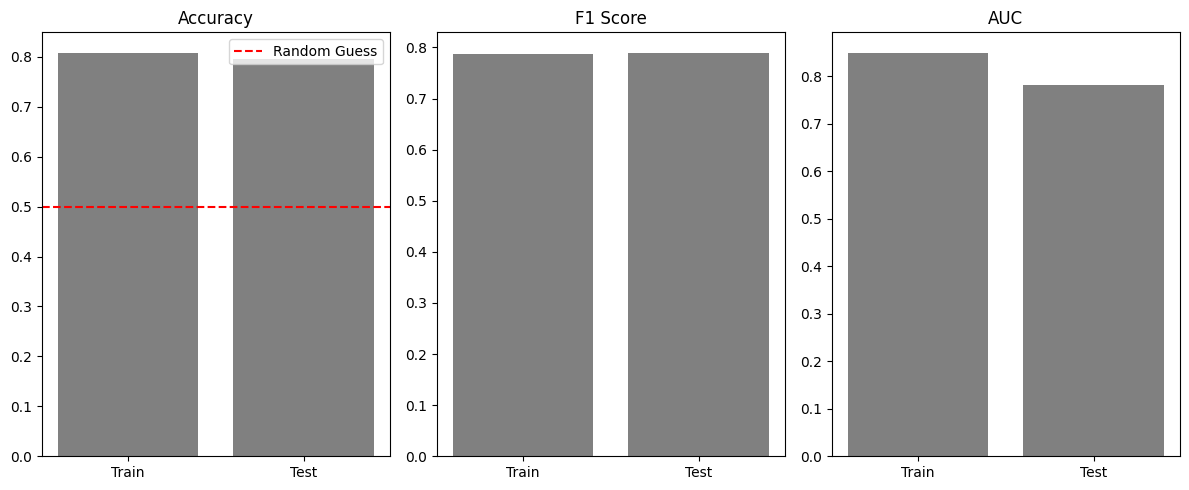

In [288]:
plot_stats(accuracy, accuracy_test, f1, f1_test, auc, auc_test)

### 2.1. Explanation of the decisions

#### Changes from Theoretical Calculations

TODO: write

#### Changes from Sampling

TODO: write

### SHAP explanation

In [297]:
column_names = list(X_test.columns)
new_cols = []
for i in range(len(column_names)):
    for ii in range(i+1, len(column_names)):
        new_cols.append(column_names[i] + "_" + column_names[ii])
column_names += new_cols
explainer = shap.KernelExplainer(neural_MCDA_compatible.predict, X_test_processed)
shap_values = explainer(X_test_processed)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'BI-RADS_Age', 'BI-RADS_Shape', 'BI-RADS_Margin', 'BI-RADS_Density', 'Age_Shape', 'Age_Margin', 'Age_Density', 'Shape_Margin', 'Shape_Density', 'Margin_Density']


  0%|          | 0/166 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.waterfall(shap_values[1])

In [ ]:
shap.plots.waterfall(shap_values[9])

In [ ]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values)

#### Conclusions

TODO: write

### 2.2. Interpretation of the model

• Based on the parameters obtained, can we say something about the user’s preferences? <br>
• What was the influence of the criteria? Are there any criteria that have no effect, or have a decisive influence? <br>
• Are there any dependencies between the criteria? <br>
• What is the nature of the criterion, gain, cost, non-monotonic? <br>
• Whether there are any preference thresholds? Are there any evaluations on criteria that are indifferent in terms of preferences? <br>
• Interpret the model by at least one (Global Surrogate, Partial Dependence Plot, Permutation Feature Importance ...) <br>

TODO: write

### ANN Model

In [266]:
lr = 1e-3
weight_decay = 1e-4
criterion = nn.BCELoss()
num_epochs = 100

Fitting Neural Network Model
Training Results - Epoch: 1  Avg accuracy: 0.4849 Avg loss: 0.6827
Training Results - Epoch: 2  Avg accuracy: 0.6672 Avg loss: 0.6441
Training Results - Epoch: 3  Avg accuracy: 0.7892 Avg loss: 0.5779
Training Results - Epoch: 4  Avg accuracy: 0.8012 Avg loss: 0.5115
Training Results - Epoch: 5  Avg accuracy: 0.8012 Avg loss: 0.4852
Training Results - Epoch: 6  Avg accuracy: 0.7937 Avg loss: 0.4744
Training Results - Epoch: 7  Avg accuracy: 0.7997 Avg loss: 0.475
Training Results - Epoch: 8  Avg accuracy: 0.8042 Avg loss: 0.4631
Training Results - Epoch: 9  Avg accuracy: 0.8087 Avg loss: 0.4549
Training Results - Epoch: 10  Avg accuracy: 0.8102 Avg loss: 0.4536
Training Results - Epoch: 11  Avg accuracy: 0.8087 Avg loss: 0.4464
Training Results - Epoch: 12  Avg accuracy: 0.7997 Avg loss: 0.4508
Training Results - Epoch: 13  Avg accuracy: 0.8133 Avg loss: 0.4512
Training Results - Epoch: 14  Avg accuracy: 0.8117 Avg loss: 0.4419
Training Results - Epoch: 15 

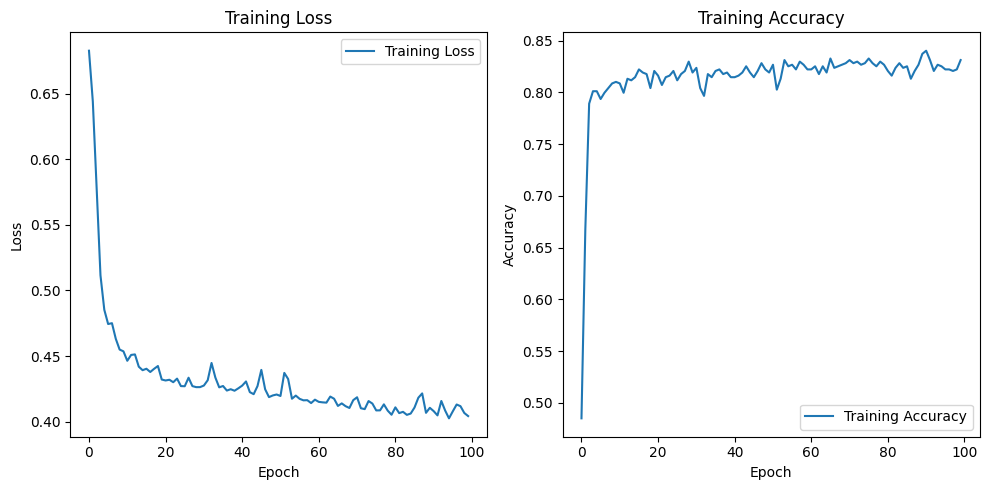

In [267]:
ann_model = ANN(len(X_train.columns), 1)
optimizer = optim.AdamW(ann_model.parameters(), lr=lr, weight_decay=weight_decay)
torch_model = Compatible_Torch_Model(ann_model, optimizer, criterion, num_epochs)
torch_model, accuracy, f1, auc, accuracy_test, f1_test, auc_test = use_model(torch_model, X_train.values, y_train.values, X_test.values, y_test.values)
ann_model = torch_model.model

In [268]:
print(f"Train set accuracy: {accuracy}")
print(f"Train set F1: {f1}")
print(f"Train set AUC: {auc}")
print(f"Test set accuracy: {accuracy_test}")
print(f"Test set F1: {f1_test}")
print(f"Test set AUC: {auc_test}")

Train set accuracy: 0.8313
Train set F1: 0.8255
Train set AUC: 0.901
Test set accuracy: 0.8012
Test set F1: 0.8156
Test set AUC: 0.8629


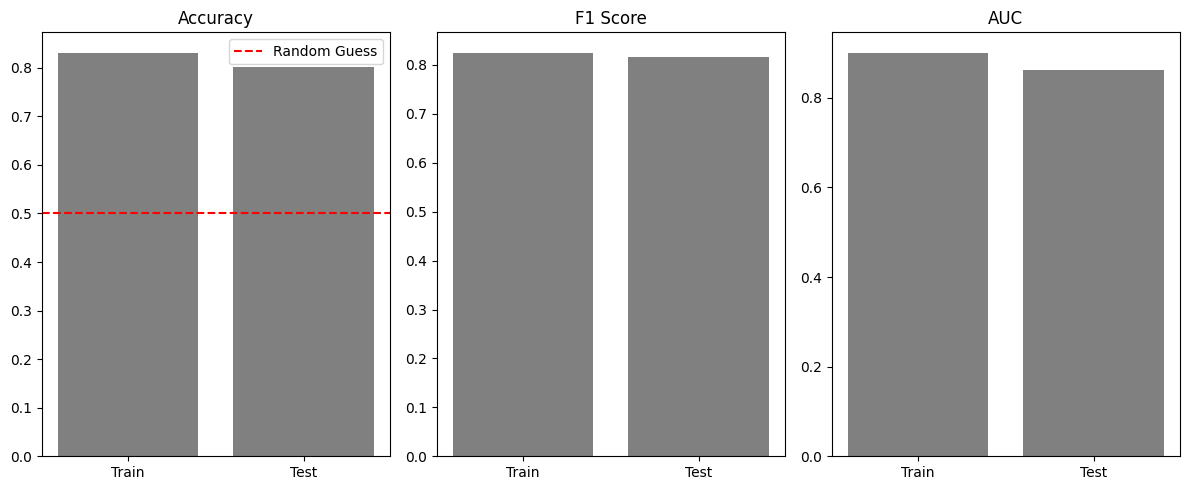

In [269]:
plot_stats(accuracy, accuracy_test, f1, f1_test, auc, auc_test)

### 2.1. Explanation of the decisions

#### Changes from Theoretical Calculations

TODO: write

#### Changes from Sampling


TODO: write

### SHAP explanation

  0%|          | 0/166 [00:00<?, ?it/s]

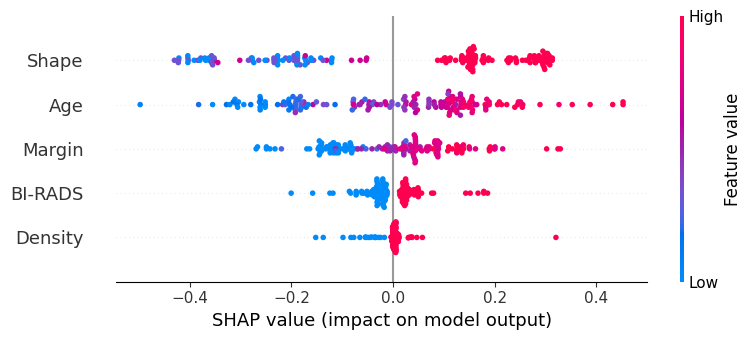

In [283]:
explainer = shap.KernelExplainer(torch_model.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

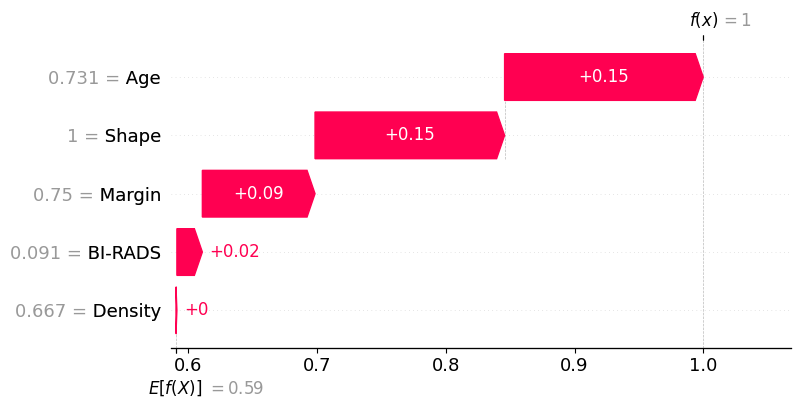

In [310]:
shap.plots.waterfall(shap_values[0])

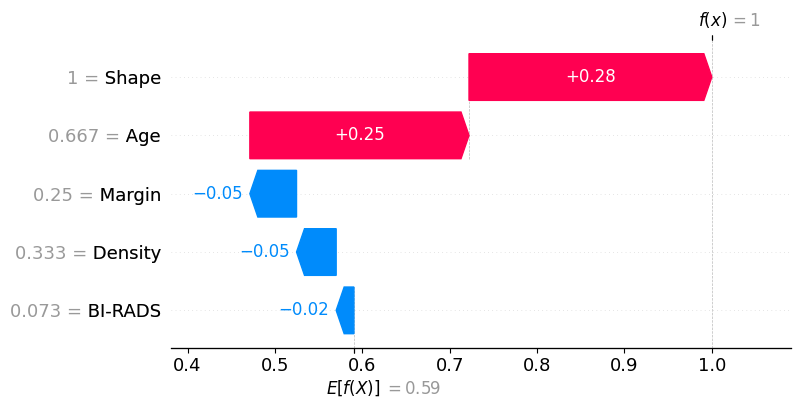

In [311]:
shap.plots.waterfall(shap_values[1])

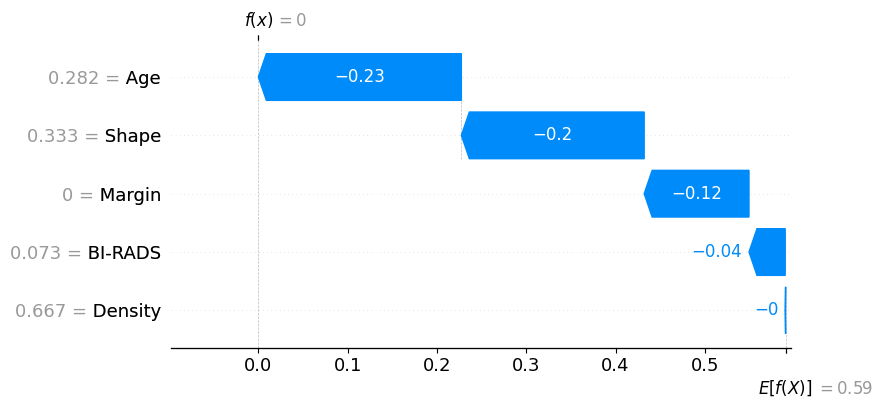

In [309]:
shap.plots.waterfall(shap_values[9])

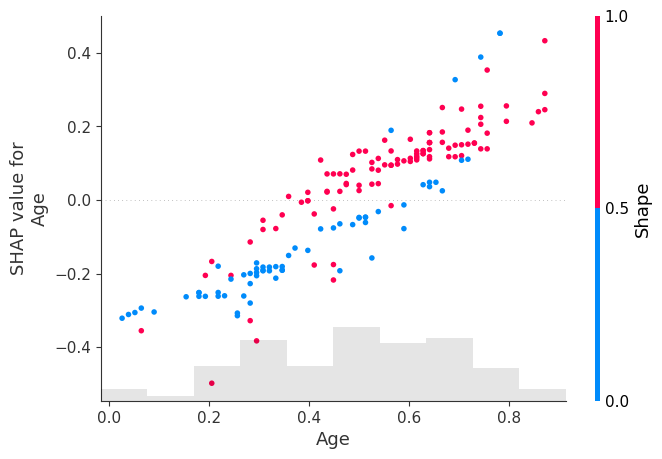

In [312]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values)

#### Conclusions

TODO: write

### 2.2. Interpretation of the model

• Based on the parameters obtained, can we say something about the user’s preferences? <br>
• What was the influence of the criteria? Are there any criteria that have no effect, or have a decisive influence? <br>
• Are there any dependencies between the criteria? <br>
• What is the nature of the criterion, gain, cost, non-monotonic? <br>
• Whether there are any preference thresholds? Are there any evaluations on criteria that are indifferent in terms of preferences? <br>
• Interpret the model by at least one (Global Surrogate, Partial Dependence Plot, Permutation Feature Importance ...) <br>

TODO: write